# SVD Decomposition

Alberto Quaini

### Import libraries

In [61]:
import numpy as np
import math
from scipy import linalg as la
import matplotlib.pyplot as plt

## Problem 1

In [62]:
def compact_svd(A, tol):
    
    eigs, V = la.eig(A.conj().T @ A)
    sigs = np.sqrt(eigs)
    arg_sort = np.argsort(sigs)[::-1]
    sigs = sigs[arg_sort]
    V = V[:, arg_sort]
    r = len(sigs[sigs > tol])
    sigs1 = sigs[:r]
    V1 = V[:,:r]
    U1 = A @ V1 / sigs1
    
    return np.real(U1), sigs1, np.real(V1.conj().T)
    

In [63]:
A = np.random.random((4, 3))
U1, sigs1, V1H = compact_svd(A, 1e-8)

In [64]:
print("Is U1 orthonormal? ", np.allclose(U1.conj().T @ U1, np.identity(np.shape(U1)[1])))
print("Is V1 orthonormal? ", np.allclose(V1H @ V1H.conj().T, np.identity(np.shape(V1H)[1])))
S = np.diag(sigs1)
print("Is U1SV1H = A? ", np.allclose(U1 @ S @ V1H, A))
U, s, Vh = la.svd(A, full_matrices=False)
print("Is V1H close to Vh? ", np.allclose(np.abs(V1H), np.abs(Vh)))
print("Is U1 close to U? ", np.allclose(np.abs(U1), np.abs(U)))

Is U1 orthonormal?  True
Is V1 orthonormal?  True
Is U1SV1H = A?  True
Is V1H close to Vh?  True
Is U1 close to U?  True


## Problem 2

In [105]:
def plot_svd(A):
    
    pi       = np.linspace(0, 2 * np.pi, 200)
    x        = np.cos(pi)
    y        = np.sin(pi)
    S        = np.vstack((x.T, y.T))
    E        = np.array([[1, 0, 0], [0, 0, 1]])
    U, s, Vh = la.svd(A)
    Sig      = np.diag(s)
    VhS      = Vh @ S
    VhE      = Vh @ E
    SigVhS   = Sig @ VhS
    SigVhE   = Sig @ VhE
    USigVhS  = U @ SigVhS
    USigVhE  = U @ SigVhE
    X        = [S, VhS, SigVhS, USigVhS]
    Y        = [E, VhE, SigVhE, USigVhE]
    titles = ['S', 'Vh S', 'Sigma Vh S', 'U Sigma Vh S']
    
    fig, axs = plt.subplots(2, 2, figsize = (8, 8))
    for i in range(4):
        axs.ravel()[i].plot(X[i][0,:], X[i][1,:])
        axs.ravel()[i].plot(Y[i][0,:], Y[i][1,:])
        axs.ravel()[i].axis('equal')
        axs.ravel()[i].set_title(titles[i])

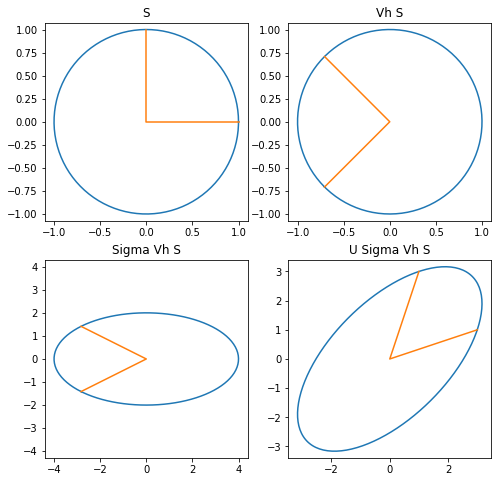

In [106]:
A = np.array([[3, 1], [1, 3]])
plot_svd(A)

## Problem 3

In [197]:
def LRM_approx(A, s):
    
    U, S, Vh = la.svd(A, full_matrices=False)
    r = np.count_nonzero(S)
    if s > r:
        raise ValueError('s is greater than the rank of A')
    
    trU = U[:,:s]
    trVh = Vh[:s,:]
    trSigma = np.diag(S)[:s,:s]
    
    As = trU @ trSigma @ trVh
    num_stored = s + trU.size + trVh.size
    
    return As, num_stored
    

In [126]:
A = np.random.random((8, 8))
As, num = LRM_approx(A, 4)
print("Rank is :", np.linalg.matrix_rank(As))
print("Number of entries stored recorde is: ", num)

Rank is : 4
Number of entries stored recorde is:  68


## Problem 4

In [185]:
def epsLRM_approx(A, eps):
    
    U, S, Vh = la.svd(A)
    Seps = S[S > eps]
    if eps < S.min():
        raise ValueError('Increase eps')
    s = len(Seps)
    
    trU = U[:,:s]
    trVh = Vh[:s,:]
    trS = S[:s]
    
    As = trU @ np.diag(trS) @ trVh
    num_stored = s + trU.size + trVh.size
    
    err = la.norm(A - As, 2)
    Stp1 = S[s]
    
    return As, num_stored, err, Stp1

In [193]:
for i in range(5):
    
    A = np.random.random((10, 10))
    As, num, err, Stp1 = epsLRM_approx(A, 1)
    print("----------------------------------------------------")
    print("2 norm-error is:\t ", round(err, 4))
    print("Singular value s+1 is:\t ", round(Stp1, 4))

----------------------------------------------------
2 norm-error is:	  0.9793
Singular value s+1 is:	  0.9793
----------------------------------------------------
2 norm-error is:	  0.9439
Singular value s+1 is:	  0.9439
----------------------------------------------------
2 norm-error is:	  0.9485
Singular value s+1 is:	  0.9485
----------------------------------------------------
2 norm-error is:	  0.9122
Singular value s+1 is:	  0.9122
----------------------------------------------------
2 norm-error is:	  0.8243
Singular value s+1 is:	  0.8243


## Problem 5

In [237]:
def image_compr(name, s):
    
    image = plt.imread(name) / 255.
    gray = len(image.shape) < 3
    if gray:
        cpr_image, j = LRM_approx(image, s)
        images = [image, cpr_image]
    else:
        R         = image[:,:,0]
        cpr_R, r  = LRM_approx(R, s)
        B         = image[:,:,1]
        cpr_B, b  = LRM_approx(B, s)
        G         = image[:,:,2]
        cpr_G, g  = LRM_approx(G, s)
        cpr_image = np.dstack((cpr_R, cpr_B, cpr_G))
        cpr_image[cpr_image < 0] = 0
        cpr_image[cpr_image > 1] = 1
        images    = [image, cpr_image]
        
    fig, axs = plt.subplots(1, 2, figsize = (8, 8))
    for i in range(2):
        axs.ravel()[i].imshow(images[i], cmap = "gray")
        axs.ravel()[i].axis("off")
        
    #diff = image.size - (r + b + g)
    #return diff

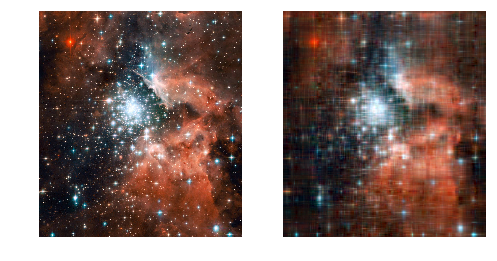

In [238]:
image_compr("hubble.jpg", 15)

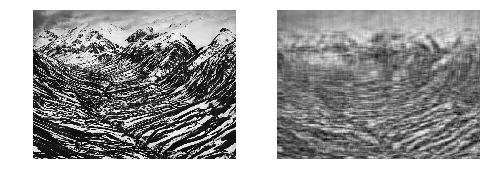

In [239]:
image_compr("salgado.jpg", 15)